# General pipeline for project 1
This is an example pipeline showing you how to  
(1) Load the provided data;  
(2) Train models on the train set, and use the validation set to evaluate your model performance;  
(3) Generate predictions (pred.csv) on the test set, which is ready for submission.

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt

### (1) Loading data
The following code shows how to load the datasets for this project.  
Among which, we do not release the labels (the "stars" column) for the test set. You may evaluate your trained model on the validation set instead.

However, your submitted predictions (``pred.csv``) should be generated on the test set.

In [2]:
def load_data(split_name='train', columns=['text', 'stars'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [3]:
train_df = load_data('train', columns=['review_id', 'text', 'stars'])
valid_df = load_data('valid', columns=['review_id', 'text', 'stars'])
# the test set labels (the 'stars' column) are not available! So the following code will instead return all columns
test_df = load_data('test', columns=['text', 'stars'])

select [review_id, text, stars] columns from the train split
Success
select [review_id, text, stars] columns from the valid split
Success
select [text, stars] columns from the test split
Failed loading specified columns... Returning all columns from the test split


In [4]:
# test_df.columns
print(train_df.columns)
print(valid_df.columns)
print(test_df.columns)
test_df

Index(['review_id', 'text', 'stars'], dtype='object')
Index(['review_id', 'text', 'stars'], dtype='object')
Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'text', 'useful',
       'user_id'],
      dtype='object')


,business_id,cool,date,funny,review_id,text,useful,user_id
0,V-qDa2kr5qWdhs7PU-l-3Q,0,2013-05-29,0,fBHWLNEJmhk6AkzmfLwWcw,Would like to give this more stars - usually I...,1,1pigoFijaHVWGrQl1_tYjw
1,C1zlvNlxlGZB8g0162QslQ,0,2012-03-02 15:51:49,0,ldEQ02aP1OeSa5N2beseNg,My wife and I took some friends here after din...,0,BKWPuPZFcGmgjRFRzoq1pw
2,0FOON_PNvG0ZxIZh6Jcv2A,0,2013-09-24 20:31:37,0,0oGr6v9VjtRsRsROGMoWTA,My husband and I had lunch here for the first ...,0,BYVYXKqNs-vv-N1ZhRMs0g
3,r49iBfbnfoK7yt4rdsL_7g,0,2018-10-20 01:34:08,0,eg5eJ5HmqXuzkxucnKvMTw,I love coming here with my friends! Great for ...,2,dpzmyNglDMeTgV3T5ylUSQ
4,xnLNPkL7bbdhD842T4oPqg,0,2016-09-25,1,BNDAe34Mxj--Brkzcfi4QA,Make sure that you double check how much these...,1,yk9wx31bfMEe_IXB8Q-ylA
...,...,...,...,...,...,...,...,...
3995,x_0Vf8AVBk_auLnNHRjoVA,2,2013-05-18 03:06:21,0,s7FLCfjgopRM6olA1NSccg,We live nearby and have stopped by this McDona...,0,Nf3VduiXhQVZRvM2GiXi-w
3996,KAJAsjVhYUPb6b_yodVqvA,0,2018-05-06 05:33:47,0,oJUnsu4PpTZz-kCE88-9uQ,It was boring as ever! All Spanish music so I ...,0,T3hk43jr0t7ZK8RPmce4sQ
3997,EnKpL0rRg1MTTKncmxbnMA,0,2012-03-21 20:49:25,0,celcHgmV26VvtzGdUFsR5w,"Was a long time customer, I was entertaining c...",1,WFWzzvWM45zTx-EShrVVxw
3998,-NR4KqS6lHseNvJ-GFzfMA,2,2016-08-14,1,69yY48SDj-UDCKlGgn-nqg,I really like this place! I like how you can t...,2,SS3sFA9ksCT9bjocM3Wbug


### (2) Training and validating 
The following example shows you how to train your model using the train set, and evaluate on the validation set.  
As an example, we only use the text data for training. Feel free to use other columns in your implementation.  

The model performance on the validation set can be roughly regarded as your models final performance, so we can use it to search for optimal hyper-parameters.

In [5]:
# Prepare the data.
# As an example, we only use the text data. 
x_train = np.array(train_df['text'])
y_train = np.array(train_df['stars'])
  
x_valid = np.array(valid_df['text'])
y_valid = np.array(valid_df['stars'])

x_test = np.array(test_df['text'])

 You can use the valid data to choose the hyperparameters.
As an example, you can decide which value of C (1 or 100) is better by evaluating on the valid data.

# Grid search

In [6]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
x_train_vec = vectorizer.fit_transform(x_train)
x_valid_vec = vectorizer.transform(x_valid)
x_test_vec = vectorizer.transform(x_test)
# define individual models
# forest_model = RandomForestClassifier()
# nb_model = GaussianNB()
logistic_model = LogisticRegression()
svc_model = SVC()
mlp_model = MLPClassifier(activation='relu', solver='adam')

# define parameter grids for each model
# forest_params = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 10, 15, 20, 25]}
logistic_params = {'C': [0.5, 1, 2, 3, 5], 'max_iter': [2000], 'solver': ['lbfgs', 'liblinear']}
svc_params = {'C': [1, 1.5, 2, 2.5], 'kernel': ['linear', 'rbf']}
mlp_params = {'hidden_layer_sizes': [(128, 128, 128), (128, 128, 128, 128), (128, 128, 128, 128, 128), (256, 256, 256, 256), (512, 512), (512, 256, 128), (128, 256, 512)], 'max_iter': [3000]}

scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_macro': make_scorer(f1_score, average='macro')}

# create the grid search objects for each model
# forest_grid_search = GridSearchCV(forest_model, forest_params, scoring=scoring, refit="f1_macro", cv=5, verbose=1, n_jobs=15)
logistic_grid_search = GridSearchCV(logistic_model, logistic_params, scoring=scoring, refit="f1_macro", cv=3, verbose=1, n_jobs=15)
svc_grid_search = GridSearchCV(svc_model, svc_params, scoring=scoring, refit="f1_macro", cv=3, verbose=1, n_jobs=15)
mlp_grid_search = GridSearchCV(mlp_model, mlp_params, scoring=scoring, refit="f1_macro", cv=3, verbose=1, n_jobs=15)

# fit the grid search objects on your training data
# forest_grid_search.fit(x_train_vec, y_train)
mlp_grid_search.fit(x_train_vec, y_train)
logistic_grid_search.fit(x_train_vec, y_train)
svc_grid_search.fit(x_train_vec, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=15,
             param_grid={'C': [1, 1.5, 2, 2.5], 'kernel': ['linear', 'rbf']},
             refit='f1_macro',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_macro': make_scorer(f1_score, average=macro)},
             verbose=1)

In [7]:
# print("tree best params")
# print(forest_grid_search.cv_results_["mean_test_f1_macro"])
# print(forest_grid_search.cv_results_["mean_test_accuracy"])
# print(forest_grid_search.best_params_)

print("logistic best params")
print(logistic_grid_search.cv_results_["mean_test_f1_macro"])
print(logistic_grid_search.cv_results_["mean_test_accuracy"])
print(logistic_grid_search.best_params_)

print("svc best params")
print(svc_grid_search.cv_results_["mean_test_f1_macro"])
print(svc_grid_search.cv_results_["mean_test_accuracy"])
print(svc_grid_search.best_params_)

print("mlp best params")
print(mlp_grid_search.cv_results_["mean_test_f1_macro"])
print(mlp_grid_search.cv_results_["mean_test_accuracy"])
print(mlp_grid_search.best_params_)

logistic best params
[0.47408471 0.43770179 0.50828467 0.4820416  0.52603674 0.50556001
 0.53295812 0.51616951 0.53409155 0.52056468]
[0.63272222 0.61911111 0.64394444 0.63638889 0.6455     0.64261111
 0.64455556 0.64494444 0.63955556 0.64094444]
{'C': 5, 'max_iter': 2000, 'solver': 'lbfgs'}
svc best params
[0.53428025 0.49582341 0.53777521 0.52641125 0.53755533 0.53140851
 0.53545667 0.53265665]
[0.64638889 0.64177778 0.64194444 0.65066667 0.63633333 0.64961111
 0.63083333 0.64988889]
{'C': 1.5, 'kernel': 'linear'}
mlp best params
[0.52454257 0.52294807 0.52363412 0.5319396  0.52484162 0.53014226
 0.5243795 ]
[0.61077778 0.60227778 0.60355556 0.60844444 0.61616667 0.61333333
 0.60938889]
{'hidden_layer_sizes': (256, 256, 256, 256), 'max_iter': 3000}


In [8]:
voting_model = VotingClassifier(estimators=[('lr', logistic_grid_search.best_estimator_), ('svc', svc_grid_search.best_estimator_), ('mlp', mlp_grid_search.best_estimator_)], voting='hard')
voting_model.fit(x_train_vec, y_train)

/home/harrison/anaconda3/envs/fyp/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


VotingClassifier(estimators=[('lr', LogisticRegression(C=5, max_iter=2000)),
                             ('svc', SVC(C=1.5, kernel='linear')),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(256, 256, 256,
                                                                256),
                                            max_iter=3000))])

# Evaluate on the validation set and predict on the test set

In [9]:
# validate on the validation set
y_pred = voting_model.predict(x_valid_vec)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))
print('f1', f1_score(y_valid, y_pred, average='macro'))

              precision    recall  f1-score   support

           1       0.71      0.84      0.77       292
           2       0.43      0.26      0.33       163
           3       0.41      0.37      0.39       232
           4       0.48      0.45      0.46       421
           5       0.78      0.83      0.81       892

    accuracy                           0.65      2000
   macro avg       0.56      0.55      0.55      2000
weighted avg       0.64      0.65      0.64      2000




[[246  23  13   2   8]
 [ 62  43  44  11   3]
 [ 24  28  85  66  29]
 [  7   2  55 189 168]
 [  6   3  10 129 744]]
accuracy 0.6535
f1 0.5513805236770588


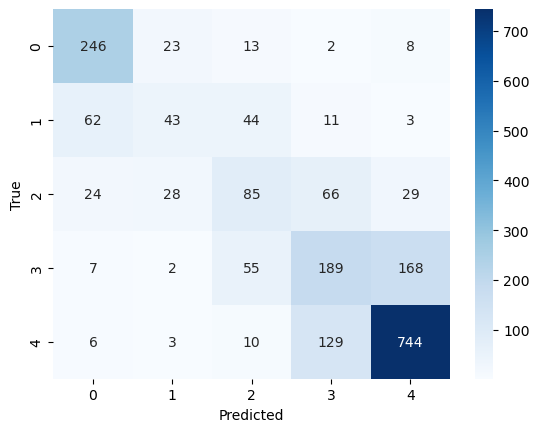

In [10]:
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
y_valid_pred = voting_model.predict(x_valid_vec)
valid_df['stars'] = y_valid_pred
valid_df[["review_id", "text", "stars"]].to_csv("data/valid_pred.csv", index=False)

In [15]:
y_test_pred = voting_model.predict(x_test_vec)
test_df['stars'] = y_test_pred
test_df[["review_id", "text", "stars"]].to_csv("data/test_pred.csv", index=False)